# Esonero 2 - 17 Maggio 2021

Completare i seguenti esercizi tramite uno o più blocchi di codice descrivendo le operazioni effettuate


# Esercizio 1

Data la seguente immagine, costruire la feature pyramid di gaussiane e descrivere il procedimento

![](figure1.jpg)

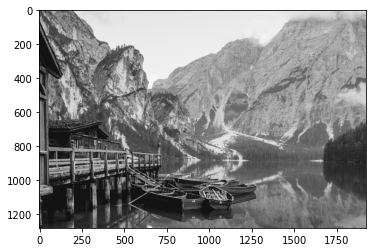

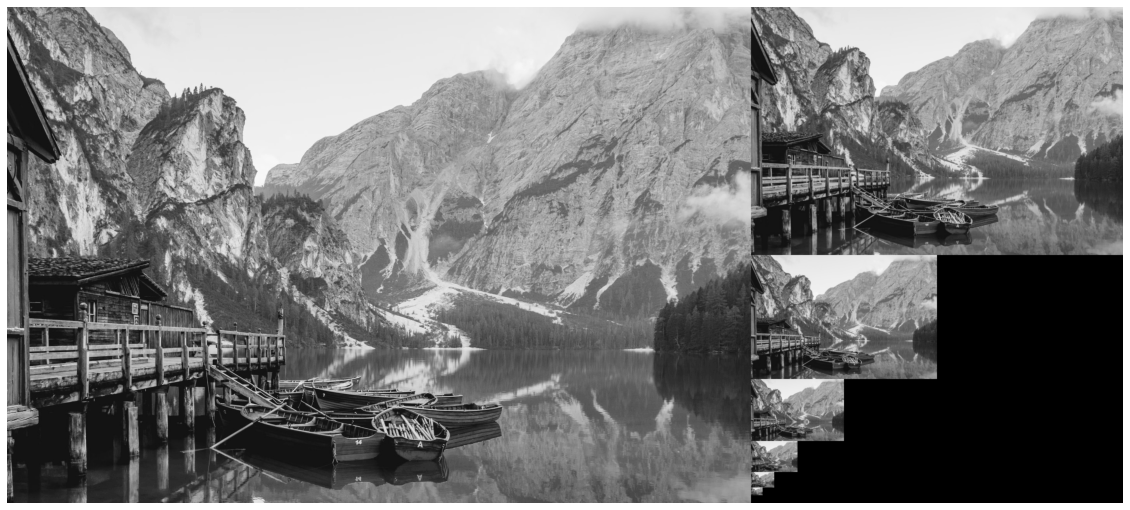

(1280, 1920)

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
image = cv2.imread('/home/figure1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')

rows,cols = image.shape

output = np.zeros((rows,cols+cols//2))

output[:rows,:cols] = image

num_octave = 6

cur_scale = image

horiz = True
rows = 0

for i in range(num_octave):
    sigma = 2**i
    cur_scale = ndimage.gaussian_filter(image,sigma)
    cur_scale = cur_scale[::2**(i+1),::2**(i+1)]
    rows_scaled, cols_scaled = cur_scale.shape
    output[rows:rows+rows_scaled,cols:cols+cols_scaled] = cur_scale
    rows += rows_scaled
        
        
plt.figure(figsize=(20, 20))

plt.imshow(output,cmap='gray')
plt.axis('off')
plt.show()

Il procedimento consiste essenzialmente nell'andare ad applicare ripetutamente un filtro gaussiano con deviazione standard crescente (raddoppia ad ogni iterazione) ad una stessa immagine, inoltre ad ogni iterazione riduciamo la scala dell'immagine, l'idea alla base è ridurre progressivamente i dettagli dell'immagine in modo da permettere ad algoritmi come SIFT di operare la feature extraction in maniera resistente alle variazioni di scala.

# Esercizio 2


Data la seguente sequenza di tensori e la funzione *f*, calcolare il gradiente per i tensori a,b,c,d,e,y. 

Descrivere come viene costruito il grafo di computazione mostrando quali operazioni vengono effettuate, cioè calcolando le derivate parziali in maniera esplicita. 

$
y = f(a,b,c,d,e) = \sum \frac {a^4 + \exp(b^2) * \sin (c*d)} {2e}
$

*non sono necessarie librerie esterne*

In [4]:
import torch
a = torch.tensor([5, 6, 7, 8, 1, 2], dtype=torch.float, requires_grad=True).view(3, 2)
b = torch.tensor([3, 3, 0, 1, 6, 2], dtype=torch.float, requires_grad=True).view(3, 2)
c = torch.tensor([1, 5, 0, 7, 4, 3], dtype=torch.float, requires_grad=True).view(3, 2)
d = torch.tensor([2, 6, 3, 8, 3, 1], dtype=torch.float, requires_grad=True).view(3, 2)
e = torch.tensor([5, 2, 1, 1, 1, 1], dtype=torch.float, requires_grad=True).view(3, 2)

a.retain_grad()
b.retain_grad()
c.retain_grad()
d.retain_grad()
e.retain_grad()

bquadro = torch.pow(b,2)
bquadro.retain_grad()
esponenziale = torch.exp(bquadro)
esponenziale.retain_grad()
prodotto_interno = c * d
prodotto_interno.retain_grad()
aquarta = torch.pow(a,4)
aquarta.retain_grad()
seno = torch.sin(prodotto_interno)
seno.retain_grad()
prodotto_esterno = esponenziale * seno
prodotto_esterno.retain_grad()
somma = aquarta + prodotto_esterno
somma.retain_grad()
o = somma / 2*e
o.retain_grad()
f = o.sum()
f.retain_grad()
print(o)
f.backward()

tensor([[ 1.9983e+04, -6.7101e+03],
        [ 1.2005e+03,  2.0473e+03],
        [-1.1566e+15,  1.1852e+01]], grad_fn=<MulBackward0>)


In [28]:
#Il grafo computazionale ha un nodo per ogni funzione, un arco rappresenta l'output di una funzione e l'input della precedente
#Ci serviamo del grafo per calcolare i gradienti
#Vediamo un esempio di calcolo
#df/db
grad_bquadro = bquadro.grad #df/dexp
djb = torch.tensor([6,6,0,2,12,4]).view(3,2).type(torch.FloatTensor)#Matrice jacobiana associata a dbquadro/db
dfdb = (djb.T).mm(bquadro.grad)

tensor([[-1.3880e+16, -4.7990e+04],
        [-4.6266e+15, -4.8023e+04]])
tensor([[ 1.1052e+05, -4.8037e+04],
        [ 0.0000e+00, -1.4177e+00],
        [-1.3880e+16,  1.5410e+01]])


# Esercizio 3

Dati due batch A e B, mostrare gli effetti della BN.

Suggerimento: calcolare gli istogrammi di A e B

# Esercizio 4

Dato il seguente frammento di codice

In [24]:
import torch
import torch.nn
image = cv2.imread('/home/Accenture-Shapes-400x400.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
tens = torch.from_numpy(image)
tens = torch.reshape(tens,(3,400,400))
tens = tens.unsqueeze(0)
conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, padding=1, stride=2)
conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
model = lambda x: conv2(conv1(x))
fms = model(tens.type(torch.FloatTensor))
fms.shape

torch.Size([1, 30, 66, 50])

Indicare giustificando la risposta qual'è il risultato per un'immagine 1x3x400x400 illustrandolo con un esempio. 

Il risultato sono 30 Feature Maps di dimensione (66,50), il fatto che che le feature maps risultino non quadrate è dovuto allo stride del secondo strato convoluzionale dal momento che è di 3 unità per le righe e di 4 per le colonne. Il numero di canali è dovuto al numero di filtri applicati nel secondo strato convoluzionale. La dimensione delle features map come sappiamo dipende dalla dimensione dei due filtri in combinazione ai parametri di padding e stride che determinano le superfici di applicazione dei filtri.

# Esercizio 5

Adattare/semplificare la rete AlexNet affinché gestisca un input di immagini 400x400

In [35]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

class LRN(nn.Module):
  def __init__(self,local_size=1,alpha=1.0,beta=0.75,ACROSS_CHANNELS=False):
    super(LRN,self).__init__()
    self.ACROSS_CHANNELS = ACROSS_CHANNELS
    if self.ACROSS_CHANNELS:
      self.average=nn.AvgPool3d(kernel_size=(local_size,1,1),stride = 1,padding=(int((local_size-1.0)/2), 0, 0))
    else:
      self.average=nn.AvgPool2d(kernel_size=local_size,stride=1,padding=int((local_size-1.0)/2))
    self.alpha = alpha
    self.beta = beta

  def forward(self,x):
    if self.ACROSS_CHANNELS:
      div = x.pow(2).unsqueeze(1)
      div = self.average(div).squeeze(1)
      div = div.mul(self.alpha).add(1.0).pow(self.beta)
    else:
      div = x.pow(2)
      div = self.average(div)
      div = div.mul(self.alpha).add(1.0).pow(self.beta)
    x = x.div(div)
    return x

class AlexNet(nn.Module):
  def __init__(self,num_classes=1000):
    super().__init__()
    #Parte convoluzionale
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2),
        LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, groups=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1),
        nn.ReLU(inplace=True)
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1),
        nn.ReLU(inplace=True)
    )
    self.layer5 = nn.Sequential(
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )
    #Parte densa
    self.layer6 = nn.Sequential(
        nn.Linear(in_features=11*11*256, out_features=4096), #Modifica numero 2
        nn.ReLU(inplace=True),
        nn.Dropout()
    )
    self.layer7 = nn.Sequential(
        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(inplace=True),
        nn.Dropout()
    )
    self.layer8 = nn.Linear(in_features=4096, out_features=num_classes)
  def forward(self,x):
    #Forward parte conv.
    x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
    print(x.size())
    #Flattening
    x = x.view(-1,256*11*11) #Modifica numero 2
    #Forward parte densa
    x = self.layer8(self.layer7(self.layer6(x)))
    return x

Per adattare AlexNet ad immagini 400x400 basta modificare il numero di neuroni del primo strato denso, diventano 256*11*11 dove (11,11) è la dimensione delle 256 feature maps che sono restituite dalla parte di feature extraction della rete. Ovviamente va modificata anche l'operazione di flattening nel metoto forward.

# Esercizio 6

Data la seguente immagine, costruire due Bounding box con IoU = 0.5. 
Descrivere tutte le operazioni effettuate

![](figure2.jpg)

In [6]:
import cv2
image = cv2.imread('figure2.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
